# Likelihood of Vector Orthogonality in High-Dimensional Spaces

>  Depends on whether you're using unit vectors or not.

- toc: true 
- badges: true
- comments: true
- author: Scott H. Hawley
- image: images/multidim_dp_summary.png

One sometimes sees claims like ["within high dimensional spaces, if you choose random vectors, they tend to be orthogonal to each other,"](https://towardsdatascience.com/loss-landscapes-and-the-blessing-of-dimensionality-46685e28e6a4) but is this true?

The answer **depends on whether you're talking about unit vectors or not**.  

Let's do some direct computation. We'll vary the number of dimensions and compute a bunch of dot products between random vectors, and then plot histograms of these dot product values.  The sharper the distribution is around the value of zero, the more likely it is for vectors to be orthogonal. 

In [1]:
#all_slow

## General Setup 

Imports and global settings

In [2]:
# General Setup
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import scipy.stats as ss

np.random.seed(42)

n = 50000  # number of random pairs of vectors to try
dims = [2,3,5,10,100,1000]  # different dimensionalities to try. Same as "D" in plots below
results = {}
test_num = 0

## Utility Routines

Define some functions that we're likely to use multiple times.

In [16]:
#show_hide 

# Utility routines 

def norm_rows(arr):   
    "normalize vectors which exist as rows with components as columns"
    arrT = arr.T                               # .T is to make broadcasting work easily 
    mags = np.sqrt( (arrT*arrT).sum(axis=0) )  # vector magnitudes
    return (arrT/mags).T

def uniform_rand(size=(10,10)):
    "random number on [-1..1]"
    return np.random.uniform(low=-1.0, high=1.0, size=size)

def softmax(x):
    "good ol' softmax function, for a bunch of row vectors"
    xT = x.T  # .T's are just to make broadcasting work out.
    vec_max = np.max(xT,axis=0)
    e_x = np.exp(xT - vec_max)   
    return (e_x / e_x.sum(axis=0)).T


def make_plot(n=n, dims=dims, title='', rand_func=uniform_rand, normalize=False,
             color='#1f77b4', xlim=None, softmax_them=False):
    """A function we'll call again & again to make plots with"""
    fig, axes = plt.subplots(2,3, figsize=(12,6))
    fig.suptitle(title, fontsize="x-large")
    axes = axes.ravel()
    sds = []                      # list of standard devations for different dims
    for i,ax in enumerate(axes):
        dim = dims[i]
        a = rand_func(size=(n,dim))
        b = rand_func(size=(n,dim))
        if softmax_them: a, b = softmax(a), softmax(b)
        if normalize: a, b = norm_rows(a), norm_rows(b)
        dots = (a*b).sum(axis=-1)

        std = np.std(dots,axis=0)   # measure standard dev of distribution of dot product
        ax.hist(dots, density=True, bins=100, label=f'D={dim}, $\sigma$={std:3.2g}', color=color)  
        sds.append(std)
        if xlim!=None: ax.set_xlim(xlim)
        ax.legend(loc=4)   # legend will show dimensions and std dev
        if i%3==0: ax.set_ylabel('Probability')
        if i>2: ax.set_xlabel('Dot product value')
    return sds, axes, fig   # return some axes & figure info too in case we want to replot

Now we can get started by looking at distributions of dot products for various kinds of vectors.  Starting with...

## Uniform distribution, Non-Unit Vectors

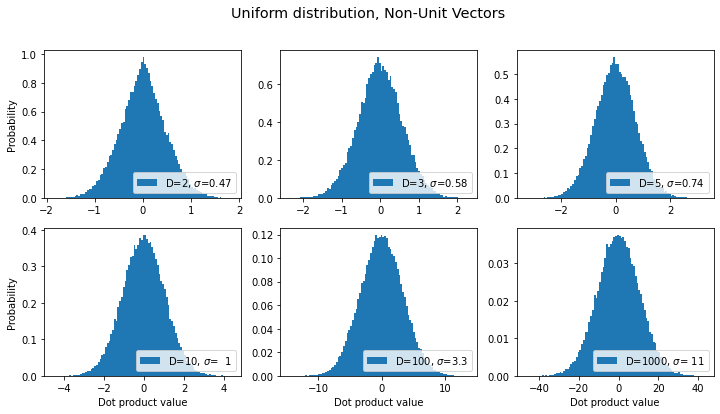

In [17]:
title = "Uniform distribution, Non-Unit Vectors"
sds, axes, fig =  make_plot(title=title)
results[1] = {'label': title, 'sds': sds}  # save for later

From the above graph, we see that as the dimensionality D increases, it's still the case that the most common dot product is zero, but the probability distribution becomes wider & flatter, i.e. the chances that a pair of random vectors are *not* orthogonal becomes increasingly *more* likely as D increases. 

## Uniform distribution, Unit vectors

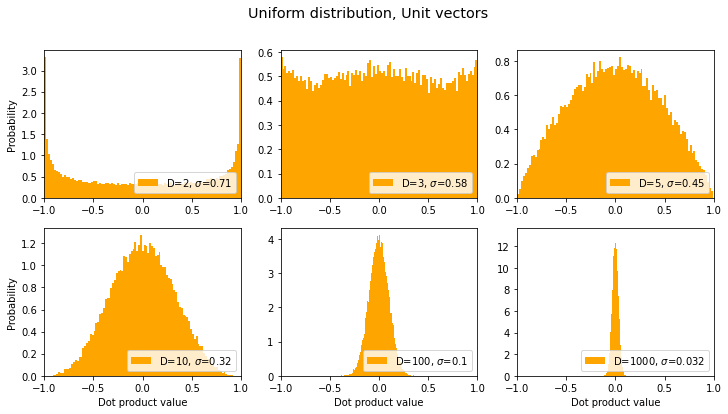

In [5]:
title = "Uniform distribution, Unit vectors"
sds, axes, fig = make_plot(title=title, normalize=True, color='orange', xlim=[-1,1])
results[2] = {'label': title, 'sds': sds }  # save for later

Wait, back up!  Those orange graphs remind me of a beta distribution.  Can we fit that?  Let's try...

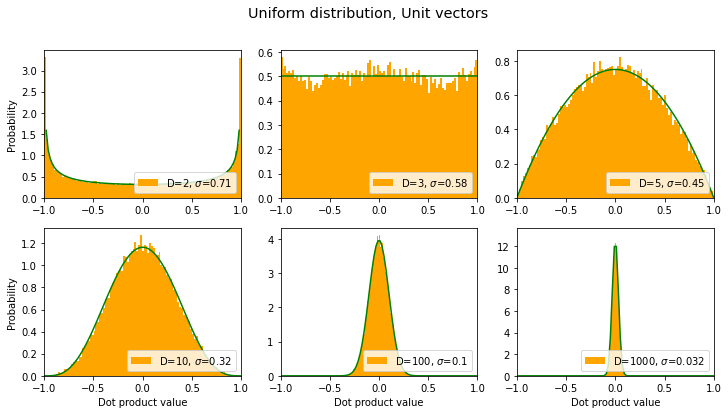

In [6]:
def fit_beta(axes):
    x = np.linspace(0,1,100)
    for i,ax in enumerate(axes):
        dim = dims[i]
        alpha = (dim-1)/2                     # this seems to work quite well
        y = 0.5*ss.beta.pdf(x, alpha, alpha)  # just messing with beta distribution
        ax.plot(2*x-1, y, color='green')
        
fit_beta(axes)
fig

Interesting that for D=2, the vectors are more likely to be parallel or antiparallel than orthogonal, but that changes as D increases.

In the above graphs we see the opposite trend from the previous non-unit-vector case: the distribution gets narrower as D increases, meaning that a given pair of random *unit* vectors are more likely to be orthogonal as D increases.

What if we draw from a normal distribution of components instead of a uniform one?

## Normal Distribution, Non-Unit Vectors

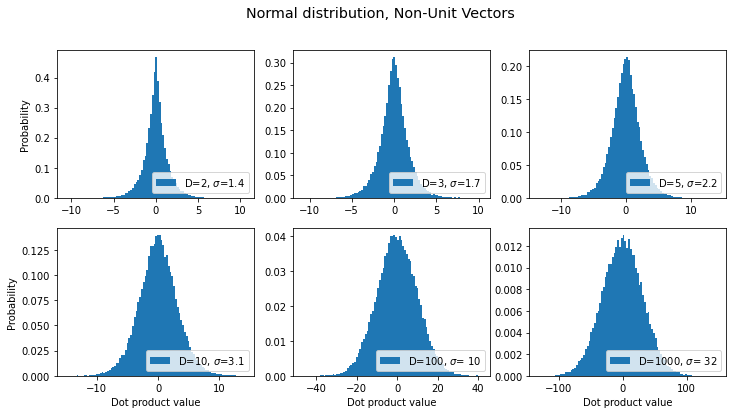

In [14]:
title = "Normal distribution, Non-Unit Vectors"
sds, axes, fig =  make_plot(title=title, rand_func=np.random.normal)
results[3] = {'label': title, 'sds': sds }

OK, same trend as before: the distribution gets wider as dimensionality increases. What about for unit vectors? 

## Normal distribution, Unit Vectors 

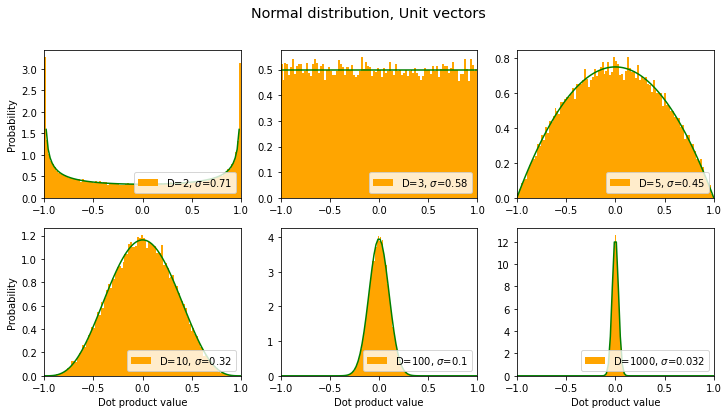

In [15]:
title = "Normal distribution, Unit vectors"
sds, axes, fig = make_plot(title=title, rand_func=np.random.normal,
                           normalize=True, color='orange', xlim=[-1,1])
results[4] = {'label': title, 'sds': sds }  # save for later
fit_beta(axes)

Looks like the normal distribution case is the same -- wow, *exactly* the same -- as the uniform distribution only more extreme: for unit vectors, the distribution gets narrower (around 0) as the dimension increases. 

> Note: If the vectors have only positive components (e.g. what you get from softmax) then you will *never* have orthogonal vectors (because they all exist in the "positive subspace").  But lets see what happens with such "softmax vectors":

## "Softmax Vectors"

If the vectors all have positive coefficients, e.g. because they are the output of a softmax function, then there's no way they can be orthogonal.  We might ask, what's the most common value for the dot product (i.e. the cosine similarity)? 

(Note that these are not unit vectors according to the L2/"Euclidean" norm, rather they are unit vectors according to an L1/"Manhattan distance" norm). 

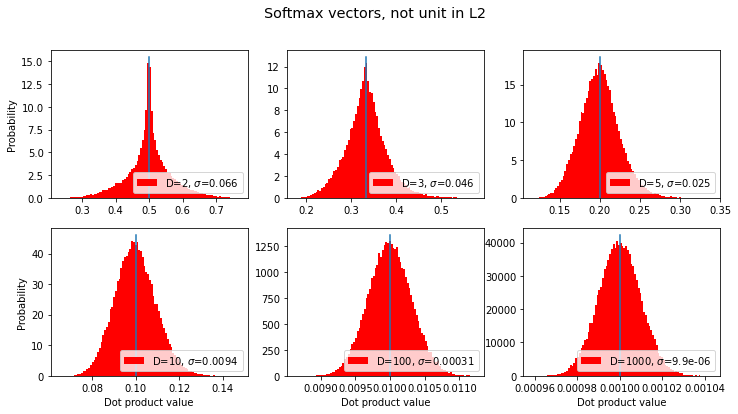

In [9]:
title = "Softmax vectors, not unit in L2"
sds, axes, fig = make_plot(title=title, normalize=False, softmax_them=True, color='red')
results[5] = {'label': title, 'sds': sds }  # save for later

for i,ax in enumerate(axes):  # seems the mean is 1/D; let's show that:
    dim = dims[i]
    ax.plot([1/dim,1/dim],[0,ax.get_ylim()[1]], label='vert bar at 1/D')   

Given that the dot product / cosine similarity for these vectors seems to consistently have a value $1/D$ for dimensions $D$, then as $D$ increases this value will go to zero, and thus the vectors will be increasingly "orthogonal". 

## Cosine Similarity for Softmax Vectors

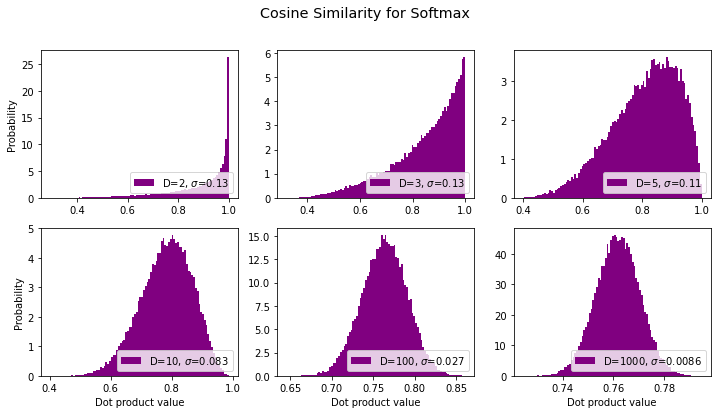

In [18]:
title = "Cosine Similarity for Softmax"
sds, axes, fig = make_plot(title=title, normalize=True, softmax_them=True, color='purple')
results[6] = {'label': title, 'sds': sds }  # save for later

...yeah I dunno 'bout that. Seems to be approaching a number a bit larger than 0.76. ??  I dunno any special number for that (e.g., it's too low to be $\pi$/4 and much too high to be $1/\sqrt{2}$). Interesting. Let's keep going to higher dimensions and see what the mean converges to:

In [11]:
# let's keep going higher
new_dims = [10000,20000,50000]
for dim in new_dims:
    a = 2*np.random.uniform(size=(n,dim)).astype(np.float32) - 1 # gotta watch for mem overruns
    b = 2*np.random.uniform(size=(n,dim)).astype(np.float32) - 1
    a, b = softmax(a), softmax(b) 
    a, b = norm_rows(a), norm_rows(b)  # normalize to get cosine
    dots = (a*b).sum(axis=-1)
    std = np.std(dots,axis=0)
    print(dim, dots.mean(), std)

10000 0.7616275 0.002721524
20000 0.7616073 0.0019327281
50000 0.7615966 0.0012098441


Likely candidate special number is the hyperbolic tangent of 1:

In [12]:
np.tanh(1)

0.7615941559557649

, though I'm not sure how that arises.  Hmmm! 

## Summary 

In all cases, the mode of the distribution is still at zero dot product.  So we can say with confidence that vectors are most likely to be (near-)orthogonal regardless of the dimensionality. However we see that although for unit vectors the distribution of dot product values gets sharper (around zero) as the number of dimensions increases, for non-unit vectors it gets *flatter*, i.e. betting on orthogonality becomes increasinly less of a safe bet as you go to higher dimensions. 

The following graph summarizes our results, in terms of the standard deviation of the distribution of dot product values:

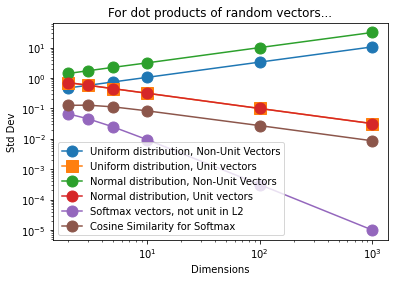

In [19]:
fig, ax = plt.subplots()
for key, val in enumerate(results):
    if val==2:  # make it so we can see the plot behind the other plot
        marker, markersize = 's-', 12
    else:
        marker, markersize = 'o-', 11
    ax.loglog(dims, results[val]['sds'], marker, markersize=markersize, label=results[val]['label'])
plt.legend()
plt.xlabel('Dimensions')
plt.ylabel('Std Dev')
plt.title("For dot products of random vectors...")
plt.show()

(where the orange line and the red line are right on top of each other) 

Thus we see that the dot products of unit vectors and "softmax vectors" (positive definite with unit L1 norm) are more likely to be zero as the dimensionality increases, whereas for other vectors it goes the other way. 

**Also: can I just say that** I really like the scaling laws apparent in that last plot.